# Package

In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.optim import optimizer
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, Dataset
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.models as models
import csv
import os
import cv2
import torchvision.transforms as transforms
import pandas as pd
import time


In [2]:
def readfile(path, label):
    true_list = []

    image_dir = sorted(os.listdir(path))  
    # print(os.listdir(path))
    # print(image_dir)
    x = np.zeros((len(image_dir), 128, 128, 3), dtype=np.uint8)
    y = np.zeros((len(image_dir)), dtype=np.uint8)
    for i, file in enumerate(image_dir):
        img = cv2.imread(os.path.join(path, file))  # os.path.join(path, file) 
        # print(img.shape)
        x[i, :, :] = cv2.resize(img, (128, 128))
        if label:
            y[i] = int(file.split("_")[0])
            
    if label:
        return x, y
    else:
        return x



workspace_dir = './data'
print("Reading data")
print("...")
train_x, train_y = readfile(os.path.join(workspace_dir, "train"), True)
print("Size of training data = {}".format(len(train_x)))
val_x, val_y = readfile(os.path.join(workspace_dir, "valid set"), True)
print("Size of validation data = {}".format(len(val_x)))
test_x, test_y = readfile(os.path.join(workspace_dir, "test"), True)
print("Size of Testing data = {}".format(len(test_x)))
# print("Reading data complicated")

# train_transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.ToTensor(),
# ])

# test_transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.ToTensor(),
# ])

# valid_transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.ToTensor(),
# ])




# preprocessing
train_tfm = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.Resize(256),
    # transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-20, 20)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_tfm = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.Resize(256),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_tfm = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.Resize(256),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Reading data
...
Size of training data = 1000
Size of validation data = 797
Size of Testing data = 1000


In [3]:
def random_seed_setup(seed):
    # For reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        print("device: cuda")
        return 'cuda'
    else:
        print("device: cpu")
        return 'cpu'
device = random_seed_setup(42096)

class ExampleDataset(Dataset):

    # data loading
    def __init__(self, x, y=None, transform=None):
        self.x = x
        # label is required to be a LongTensor
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:  # 如果没有标签那么只返回X
            return X



# train_set = ExampleDataset(train_x, train_y, train_transform)
# train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
# valid_set = ExampleDataset(val_x, val_y, valid_transform)
# valid_dataloader = DataLoader(valid_set, batch_size=1)

#preprocessing.ver
train_set = ExampleDataset(train_x, train_y, train_tfm)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_set = ExampleDataset(val_x, val_y, valid_tfm)
valid_dataloader = DataLoader(valid_set, batch_size=1)


device: cuda


# Normalization

In [4]:
# mean = dataset.x.data.mean(dim=0).unsqueeze(0)
# std = dataset.x.data.std(dim=0).unsqueeze(0)
# dataset.x = (dataset.x - dataset.x.data.mean(dim=0).unsqueeze(0)) / dataset.x.data.std(dim=0).unsqueeze(0)
# print(dataset.x)
# print(dataset.y)

# Build model

In [5]:
# dataloader = DataLoader(dataset=train_loader, batch_size=2, shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# for features, labels in dataloader:
#   print(features)
#   print(labels)
torch.cuda.empty_cache()

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # image shape is 30 * 38 * 7, where 1 is one color channel
        # conv2d(in, out, kernal, stride, pad)
        # size = (input - kernal - stride + 2 * padding ) / stride
        # batch size only affected by batch norm
        # size : input
        self.cnn = nn.Sequential(
            # # normal
            #input: [32, 3, 128, 128]
            
            # nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            # nn.BatchNorm2d(64),
            # nn.ReLU(),
            # nn.MaxPool2d(2, 2, 0),  # [64, 64, 64]

            # nn.Conv2d(64, 128, 3, 1, 1),  # [64, 64, 64]
            # nn.BatchNorm2d(128),
            # nn.ReLU(),
            # nn.MaxPool2d(2, 2, 0),  # [128, 32, 32]


            # # adjusted, kernal == 9
            # # input[32, 3, 128, 128]
            
            # nn.Conv2d(3, 64, 9, 1, 1), # [64, 122, 122]
            # nn.BatchNorm2d(64),
            # nn.ReLU(),
            # nn.MaxPool2d(2, 2, 0), # [64, 61, 61]

            # nn.Conv2d(64, 128, 9, 1, 1), # [64, 55, 55]
            # nn.BatchNorm2d(128),
            # nn.ReLU(),
            # nn.MaxPool2d(2, 2, 0),  # 無條件捨去
            
            
            # adjusted 2, stride2 == 2
            # input[32, 3, 128, 128]
            
            nn.Conv2d(3, 64, 3, 1, 1), # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 2, 1), # [64, 65, 65]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),  # 無條件捨去
            )
        self.fc = nn.Sequential(
            # nn.Linear(128 * 32 * 32, 1024), # baseline
            nn.Linear(128 * 16 * 16, 1024), # stride = 2
            # nn.Linear(128 * 27 * 27, 1024), #adjusted kernal 9
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        # print(out.shape) # check shape
        out = out.view(out.size()[0], -1)
        return self.fc(out)

model = ConvNet()
model.to(device)
FILE = 'model_state_dict.pt'

# Fit dataset

epoch: 0, loss: 132.48617750033736
epoch: 1, loss: 7.805133704096079
epoch: 2, loss: 6.604982919991016
epoch: 3, loss: 4.565224029123783
epoch: 4, loss: 4.294171542860568
epoch: 5, loss: 4.766562801785767
epoch: 6, loss: 3.782030614092946
epoch: 7, loss: 3.4047304103150964
epoch: 8, loss: 3.089878265745938
epoch: 9, loss: 2.722514576278627
epoch: 10, loss: 2.426239682827145
epoch: 11, loss: 2.5409393780864775
epoch: 12, loss: 2.2967712520621717
epoch: 13, loss: 3.7106858522165567
epoch: 14, loss: 2.3750510797835886


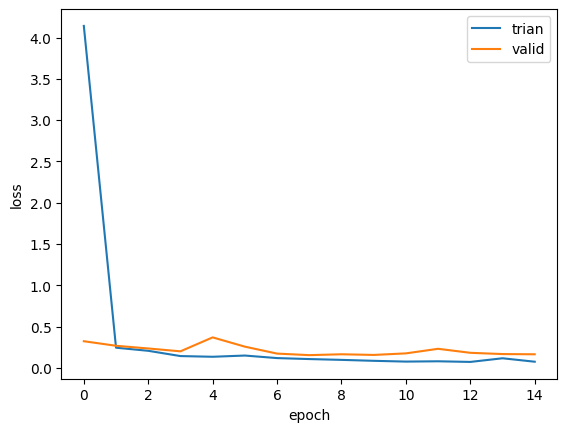

In [6]:
criterion = nn.CrossEntropyLoss()  # loss
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
epochs = 15

def save_model():
    path = r"C:\Users\JasonWei\OneDrive\桌面\DL final"
    torch.save(model.state_dict(), os.path.join(path,"Network.pth"))


train_graph = []
valid_graph = []
optimal_loss = 100
for epoch in range(epochs):
    train_loss = 0
    valid_loss = 0
    for x, y in train_loader:
        x , y = x.to(device), y.to(device)
        # print(x.shape)
        pred = model(x)
        loss = criterion(pred, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print('epoch: {}, loss: {}'.format(epoch, train_loss))
    train_loss = train_loss / len(train_loader)
    # torch.save({'model_state_dict': model.state_dict()}, FILE)
    if train_loss < optimal_loss:
        optimal_loss = train_loss
        save_model()
        
    train_graph.append(train_loss)
    with torch.no_grad():
        for x, y in valid_dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            valid_loss += loss.item()
            
        valid_loss_value = valid_loss / len(valid_dataloader)
        valid_graph.append(valid_loss_value)

plt.plot(train_graph, label='train_loss')
plt.plot(valid_graph, label='valid_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['trian', 'valid'], loc='upper right')

# Re-load best weight, and prediction test dataset

In [7]:

model.load_state_dict(torch.load(r"./Network.pth"))
model.eval()

# test_set = ExampleDataset(test_x, transform=test_transform)
test_set = ExampleDataset(test_x, transform=test_tfm) #preprocessing.ver
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)


# dataset2.x = (dataset2.x - mean) / std
# print(dataset2.x)


# save test prediction, and plot figure

In [8]:
clist = []
dlist = []
pred_value = []
true_value = []
for batch, X in enumerate(test_loader):
      X = X.to(device)
      pred = model(X)
      # print(y)
      test_label = np.argmax(pred.cpu().data.numpy(), axis=1)
      # print(pred)
      clist.append(test_label)

for i in range(len(test_loader)):
  pred_value.append(clist[i][0])
# print(pred_value)

for i in range(len(test_y)):
  true_value.append(test_y[i])


# Upload Format

In [9]:
tp = 0
tn = 0
fp = 0
fn = 0

for i in range(len(test_y)):
    if pred_value[i] == 0 and true_value[i] == 0:
        tp += 1
    elif pred_value[i] == 1 and true_value[i] == 1:
        tn += 1
    elif pred_value[i] == 1 and true_value[i] == 0:
        fp += 1
        # print("NM", i + 501)
    else:
        fn += 1
        # print("WM", i)

recall = tp / (tp + fn)
precision = tp / (tp + fp)
score = 2 * recall * precision / (precision + recall)
print("confusion matrix :")
print(tp, fp)
print(fn, tn)
print("precison:", precision)
print("recall:", recall)
print("F1 score: ",score)
print("accuracy:", (tp + tn) / (tp + tn + fp + fn))

confusion matrix :
493 7
40 460
precison: 0.986
recall: 0.924953095684803
F1 score:  0.9545014520813165
accuracy: 0.953
